Title: Predictive Maintenance of Aircraft Engines using LSTM-based Deep Learning Models


1. Introduction

This study presents the implementation of a deep learning-based predictive maintenance system that leverages Long Short-Term Memory (LSTM) networks to analyze time-series sensor data for fault prediction in aircraft engines. The approach addresses the limitations of traditional corrective and preventive maintenance methods by providing more accurate estimations of equipment health and remaining useful life (RUL).

2. Dataset Overview

The dataset used in this project is a simulated representation of aircraft engine operations.

The data includes:

Training data: Multivariate time-series data for each engine unit with 21 sensor measurements per cycle.

Test data: Similar format but without known failure points.

Ground truth: True RUL values for engines in the test set.

The dataset supports both:

Regression modeling: Predict how many more cycles an in-service engine will last before failure.

Binary classification: Determine whether an engine will fail within a specified time window (w1 = 30 cycles).

3. Methodology

3.1 Data Preprocessing

Each unit is sorted by its cycle index.

The Remaining Useful Life (RUL) is computed for each record.

Label columns are generated for classification based on thresholds w0 and w1.

Sensor values and operational settings are normalized using Min-Max scaling.

A sliding window of 50 cycles is used to construct sequences for model training.

3.2 Model Architecture

Two separate LSTM-based models are implemented:

(A) Binary Classification Model

Architecture: Two LSTM layers (100, 50 units), each followed by dropout.

Final layer: Sigmoid activation for binary prediction.

Objective: Classify whether an engine is likely to fail within 30 cycles.

Training: Binary cross-entropy loss, Adam optimizer, and accuracy as the metric.

(B) Regression Model

Architecture: LSTM layers (128, 64 units) with dropout layers.

Final layer: Dense linear activation for continuous RUL prediction.

Objective: Predict exact RUL in cycles.

Training: Mean squared error loss, Adam optimizer, and metrics include MAE and R².

Labels and predictions are scaled and inverse-transformed using MinMaxScaler.

4. Evaluation and Results

4.1 Binary Classification Results:

Accuracy: 98.9%

Precision: 95.17%

Recall: 94.71%

F1 Score: 0.949

Confusion matrix confirms strong performance in both classes with minimal false negatives.

4.2 Regression Results:

Scaled MAE: ~0.0506

Scaled R^2 Score: 0.7151

Real-world MAE: 15.74 cycles

RMSE: 22.02 cycles

The model shows good alignment between predicted and actual RUL values, as confirmed by visual plots and statistical metrics.

5. Comparative Analysis

The results are compared against previous experimental outcomes from the source project:

Metric

Prior Model

This Study

MAE (Regression)

12

15.74

R² (Regression)

0.7965

0.7151

Accuracy (Binary)

0.97

0.989

Precision (Binary)

0.92

0.9517

Recall (Binary)

1.00

0.947

F1 Score (Binary)

0.96

0.949

While the RUL prediction model shows a slightly higher MAE, the binary classification performance exceeds the baseline across all metrics.




# Importing libraries


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1695238462655750742
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4312818152100104698
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
!cat /proc/meminfo

MemTotal:       13289416 kB
MemFree:         5552980 kB
MemAvailable:   10666836 kB
Buffers:          449008 kB
Cached:          4860344 kB
SwapCached:            0 kB
Active:           849556 kB
Inactive:        6413136 kB
Active(anon):       2204 kB
Inactive(anon):  1975000 kB
Active(file):     847352 kB
Inactive(file):  4438136 kB
Unevictable:           8 kB
Mlocked:               8 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               320 kB
Writeback:             0 kB
AnonPages:       1953384 kB
Mapped:           971156 kB
Shmem:             23856 kB
KReclaimable:     138932 kB
Slab:             192052 kB
SReclaimable:     138932 kB
SUnreclaim:        53120 kB
KernelStack:        5920 kB
PageTables:        29164 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6644708 kB
Committed_AS:    4216720 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       88428 kB
VmallocChunk:    

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.186
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_test.txt -O PM_test.txt
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_train.txt -O PM_train.txt
!wget -q https://raw.githubusercontent.com/umbertogriffo/Predictive-Maintenance-using-LSTM/master/Dataset/PM_truth.txt -O PM_truth.txt

In [ ]:
!ls

binary_model.h5		 model_r2.png		      PM_truth.txt
binary_submit_test.csv	 model_regression_loss.png    regression_model.h5
binary_submit_train.csv  model_regression_verify.png  sample_data
model_accuracy.png	 model_verify.png	      submit_test.csv
model_loss.png		 PM_test.txt		      submit_train.csv
model_mae.png		 PM_train.txt


# Binary classification
Predict if an asset will fail within certain time frame

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'binary_model.h5'

## Data Ingestion

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


## Data Preprocessing

In [ ]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
# generate label columns for training data
# we will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)


# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

## LSTM

In [ ]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,651 (315.04 KB)

 Trainable params: 80,651 (315.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


75/75 - 3s - 45ms/step - accuracy: 0.8949 - loss: 0.2530 - val_accuracy: 0.9386 - val_loss: 0.1310
Epoch 2/100


75/75 - 1s - 11ms/step - accuracy: 0.9602 - loss: 0.0999 - val_accuracy: 0.9847 - val_loss: 0.0584
Epoch 3/100
75/75 - 1s - 16ms/step - accuracy: 0.9681 - loss: 0.0784 - val_accuracy: 0.9706 - val_loss: 0.0619
Epoch 4/100


75/75 - 1s - 18ms/step - accuracy: 0.9685 - loss: 0.0771 - val_accuracy: 0.9795 - val_loss: 0.0552
Epoch 5/100
75/75 - 1s - 17ms/step - accuracy: 0.9735 - loss: 0.0652 - val_accuracy: 0.9527 - val_loss: 0.1016
Epoch 6/100


75/75 - 1s - 11ms/step - accuracy: 0.9751 - loss: 0.0615 - val_accuracy: 0.9834 - val_loss: 0.0401
Epoch 7/100
75/75 - 1s - 10ms/step - accuracy: 0.9730 - loss: 0.0681 - val_accuracy: 0.9783 - val_loss: 0.0506
Epoch 8/100


75/75 - 1s - 11ms/step - accuracy: 0.9728 - loss: 0.0648 - val_accuracy: 0.9808 - val_loss: 0.0371
Epoch 9/100
75/75 - 1s - 12ms/step - accuracy: 0.9779 - loss: 0.0542 - val_accuracy: 0.9795 - val_loss: 0.0461
Epoch 10/100


75/75 - 1s - 18ms/step - accuracy: 0.9759 - loss: 0.0576 - val_accuracy: 0.9847 - val_loss: 0.0317
Epoch 11/100
75/75 - 1s - 14ms/step - accuracy: 0.9773 - loss: 0.0526 - val_accuracy: 0.9642 - val_loss: 0.0905
Epoch 12/100
75/75 - 1s - 10ms/step - accuracy: 0.9774 - loss: 0.0538 - val_accuracy: 0.9898 - val_loss: 0.0332
Epoch 13/100
75/75 - 1s - 10ms/step - accuracy: 0.9815 - loss: 0.0469 - val_accuracy: 0.9898 - val_loss: 0.0343
Epoch 14/100
75/75 - 1s - 17ms/step - accuracy: 0.9799 - loss: 0.0462 - val_accuracy: 0.9719 - val_loss: 0.0609
Epoch 15/100
75/75 - 1s - 10ms/step - accuracy: 0.9727 - loss: 0.0655 - val_accuracy: 0.9808 - val_loss: 0.0458
Epoch 16/100
75/75 - 1s - 10ms/step - accuracy: 0.9771 - loss: 0.0540 - val_accuracy: 0.9757 - val_loss: 0.0470
Epoch 17/100


75/75 - 1s - 10ms/step - accuracy: 0.9785 - loss: 0.0527 - val_accuracy: 0.9898 - val_loss: 0.0283
Epoch 18/100
75/75 - 1s - 10ms/step - accuracy: 0.9805 - loss: 0.0461 - val_accuracy: 0.9795 - val_loss: 0.0469
Epoch 19/100
75/75 - 1s - 16ms/step - accuracy: 0.9809 - loss: 0.0456 - val_accuracy: 0.9719 - val_loss: 0.0800
Epoch 20/100
75/75 - 1s - 10ms/step - accuracy: 0.9784 - loss: 0.0511 - val_accuracy: 0.9757 - val_loss: 0.0484
Epoch 21/100
75/75 - 1s - 10ms/step - accuracy: 0.9830 - loss: 0.0417 - val_accuracy: 0.9770 - val_loss: 0.0463
Epoch 22/100
75/75 - 1s - 12ms/step - accuracy: 0.9834 - loss: 0.0413 - val_accuracy: 0.9872 - val_loss: 0.0343
Epoch 23/100
75/75 - 1s - 18ms/step - accuracy: 0.9817 - loss: 0.0434 - val_accuracy: 0.9834 - val_loss: 0.0416
Epoch 24/100
75/75 - 1s - 11ms/step - accuracy: 0.9817 - loss: 0.0435 - val_accuracy: 0.9834 - val_loss: 0.0330
Epoch 25/100
75/75 - 1s - 16ms/step - accuracy: 0.9820 - loss: 0.0443 - val_accuracy: 0.9744 - val_loss: 0.0516
Epoch

## Model Evaluation on Test set

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


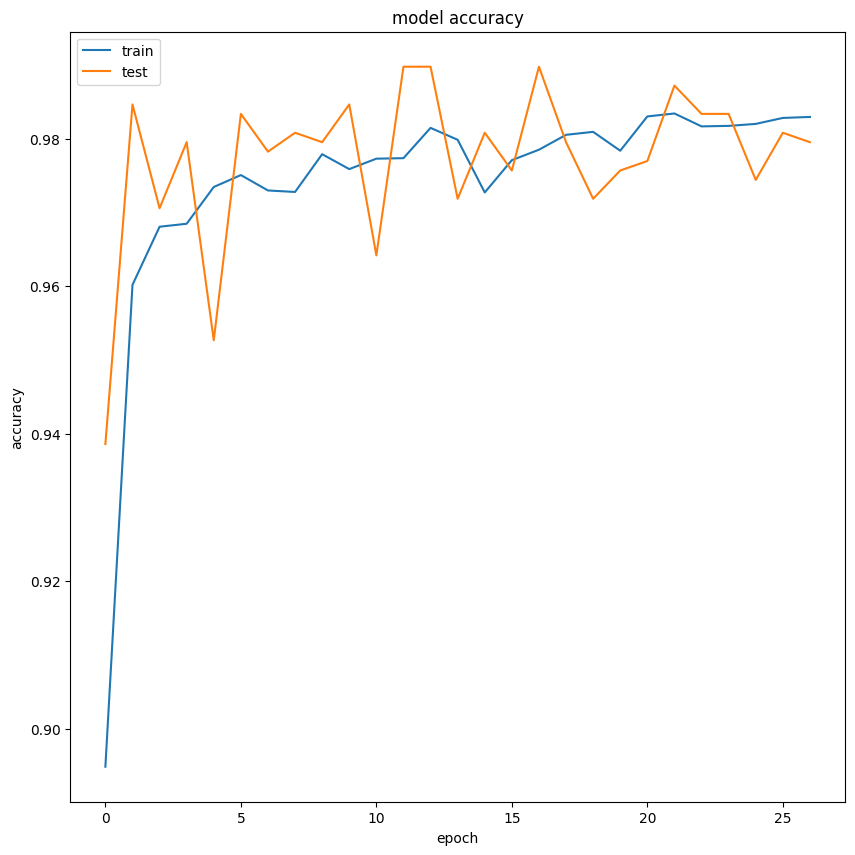

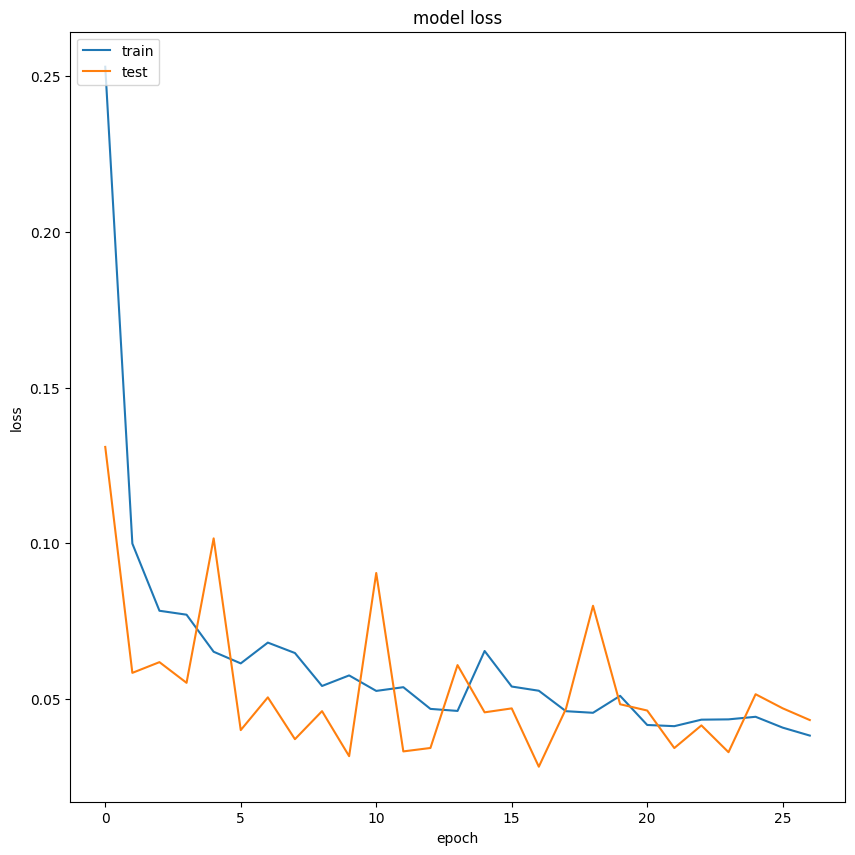

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9875 - loss: 0.0290
Accurracy: 0.9863092303276062
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12374   157]
 [   57  3043]]
precision =  0.9509375 
 recall =  0.9816129032258064


In [ ]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array, verbose=1, batch_size=200) > 0.5).astype(int)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Evaluation on Validation set

3/3 - 1s - 180ms/step - accuracy: 0.9785 - loss: 0.0440
Accurracy: 0.9784946441650391
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[67  1]
 [ 1 24]]
Precision:  0.96 
 Recall:  0.96 
 F1-score: 0.96


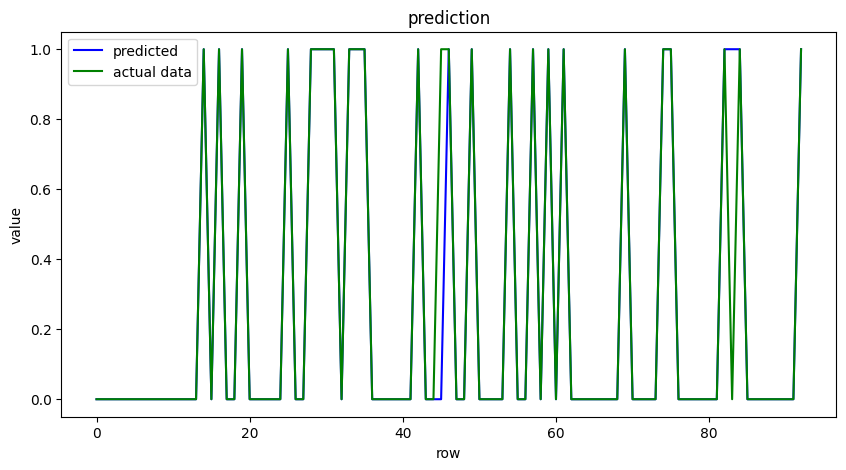

In [ ]:
# We pick the last sequence for each id in the test data

seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels

#print("y_mask")
# serve per prendere solo le label delle sequenze che sono almeno lunghe 50
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
#print("y_mask")
#print(y_mask)
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path)

# test metrics
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Accurracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = (estimator.predict(seq_array_test_last) > 0.5).astype(int)
y_true_test = label_array_test_last

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)

# Avoid division by zero when calculating F1-score
if precision_test + recall_test == 0:
    f1_test = 0  # or np.nan, depending on how you want to handle this case
else:
    f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)

print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )


# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

# Regression
How many more cycles an in-service engine will last before it fails?

In [ ]:
import keras
import keras.backend as K
from keras.layers import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

## Data Ingestion

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

## Data Preprocessing

In [ ]:
##################################
# Data Preprocessing
##################################

#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)

######
# TEST
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL'])
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5  ...       s13       s14       s15  s16       s17  s18  s19       s20  \
0  0.0  ...  0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0  0.558140   
1  0.0  ...  0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0  0.682171   
2  0.0  ...  0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0  0.728682   
3  0.0  ...  0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0  0.666667   
4  0.0  ...  0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0  0.658915   

        s21  cycle_norm  
0  0.6

(15631, 1)

## LSTM

In [ ]:
import tensorflow as tf

def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

from sklearn.preprocessing import MinMaxScaler

rul_scaler = MinMaxScaler()
label_array_scaled = rul_scaler.fit_transform(label_array)

# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = 1  # Single regression target

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, nb_features)))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(nb_out))
model.add(Activation("linear"))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae', r2_keras])

print(model.summary())

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(seq_array, label_array_scaled,
                    epochs=100,
                    batch_size=256,
                    validation_split=0.05,
                    verbose=2,
                    callbacks=callbacks)


# list all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 50, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,321 (501.25 KB)

 Trainable params: 128,321 (501.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100

Epoch 1: val_loss improved from inf to 0.02018, saving model to regression_model.h5


59/59 - 3s - 56ms/step - loss: 0.0310 - mae: 0.1281 - r2_keras: -2.7014e+04 - val_loss: 0.0202 - val_mae: 0.1211 - val_r2_keras: -1.8986e+00 - learning_rate: 1.0000e-03
Epoch 2/100

Epoch 2: val_loss improved from 0.02018 to 0.01598, saving model to regression_model.h5


59/59 - 1s - 13ms/step - loss: 0.0174 - mae: 0.0997 - r2_keras: -1.1077e+02 - val_loss: 0.0160 - val_mae: 0.1060 - val_r2_keras: 0.1386 - learning_rate: 1.0000e-03
Epoch 3/100

Epoch 3: val_loss improved from 0.01598 to 0.01558, saving model to regression_model.h5


59/59 - 1s - 13ms/step - loss: 0.0143 - mae: 0.0890 - r2_keras: -1.0286e+02 - val_loss: 0.0156 - val_mae: 0.1029 - val_r2_keras: -9.7335e-02 - learning_rate: 1.0000e-03
Epoch 4/100

Epoch 4: val_loss did not improve from 0.01558
59/59 - 1s - 21ms/step - loss: 0.0133 - mae: 0.0849 - r2_keras: -6.1070e+03 - val_loss: 0.0209 - val_mae: 0.0962 - val_r2_keras: -3.3432e+00 - learning_rate: 1.0000e-03
Epoch 5/100

Epoch 5: val_loss did not improve from 0.01558
59/59 - 1s - 12ms/step - loss: 0.0148 - mae: 0.0893 - r2_keras: -2.6881e+01 - val_loss: 0.0175 - val_mae: 0.1095 - val_r2_keras: 0.1711 - learning_rate: 1.0000e-03
Epoch 6/100

Epoch 6: val_loss improved from 0.01558 to 0.01375, saving model to regression_model.h5


59/59 - 1s - 22ms/step - loss: 0.0122 - mae: 0.0800 - r2_keras: -2.0439e+02 - val_loss: 0.0138 - val_mae: 0.0844 - val_r2_keras: -1.5800e-01 - learning_rate: 1.0000e-03
Epoch 7/100

Epoch 7: val_loss improved from 0.01375 to 0.01209, saving model to regression_model.h5


59/59 - 1s - 12ms/step - loss: 0.0116 - mae: 0.0776 - r2_keras: -4.2162e+02 - val_loss: 0.0121 - val_mae: 0.0830 - val_r2_keras: -1.2238e+00 - learning_rate: 1.0000e-03
Epoch 8/100

Epoch 8: val_loss did not improve from 0.01209
59/59 - 1s - 13ms/step - loss: 0.0100 - mae: 0.0715 - r2_keras: -3.3868e+03 - val_loss: 0.0627 - val_mae: 0.1740 - val_r2_keras: -3.0975e+00 - learning_rate: 1.0000e-03
Epoch 9/100

Epoch 9: val_loss did not improve from 0.01209
59/59 - 1s - 12ms/step - loss: 0.0154 - mae: 0.0900 - r2_keras: -1.7636e+04 - val_loss: 0.0273 - val_mae: 0.1396 - val_r2_keras: -2.8144e+00 - learning_rate: 1.0000e-03
Epoch 10/100

Epoch 10: val_loss did not improve from 0.01209
59/59 - 1s - 13ms/step - loss: 0.0160 - mae: 0.0934 - r2_keras: -8.2227e+02 - val_loss: 0.0145 - val_mae: 0.0938 - val_r2_keras: 0.1929 - learning_rate: 1.0000e-03
Epoch 11/100

Epoch 11: val_loss did not improve from 0.01209
59/59 - 1s - 23ms/step - loss: 0.0129 - mae: 0.0826 - r2_keras: -8.5247e+03 - val_los

## Model Evaluation on Test set

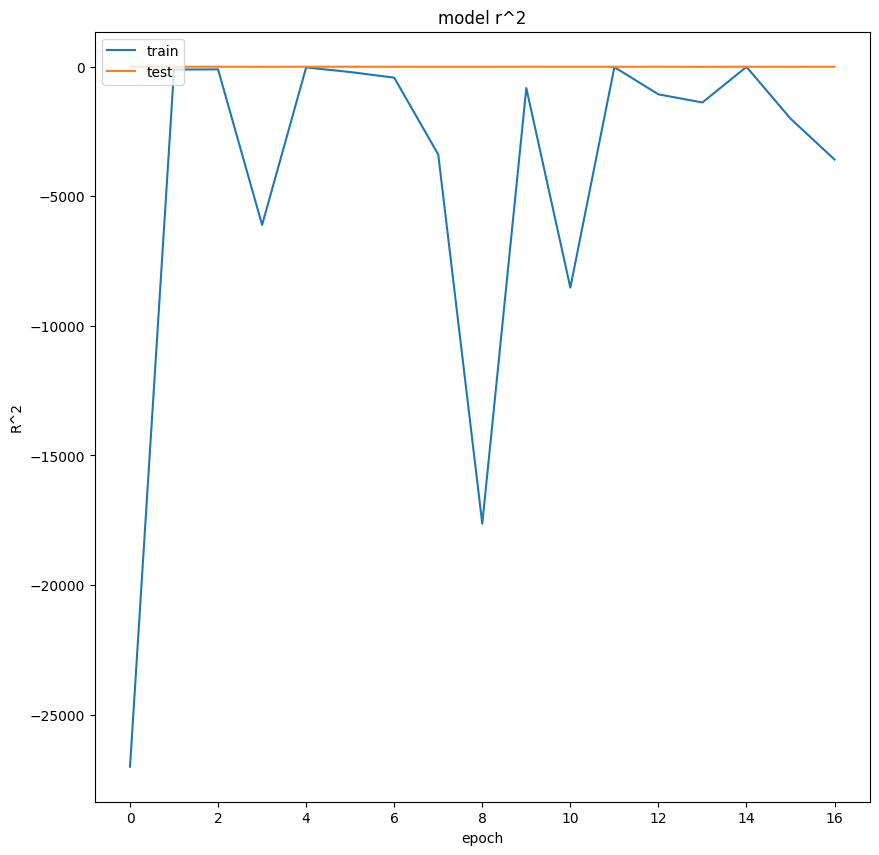

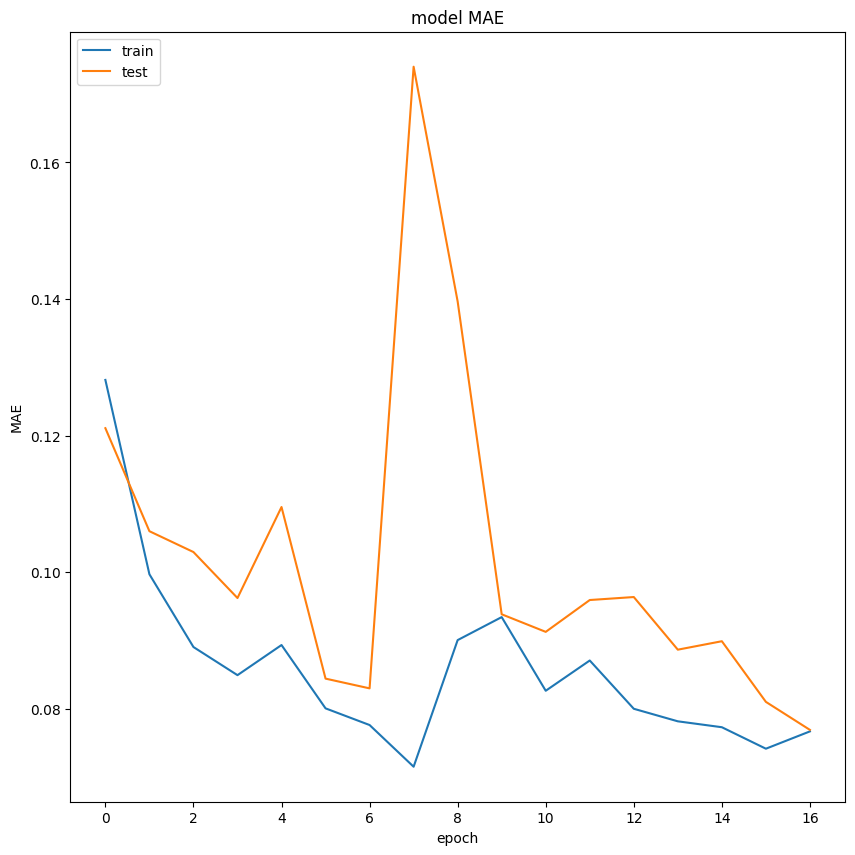

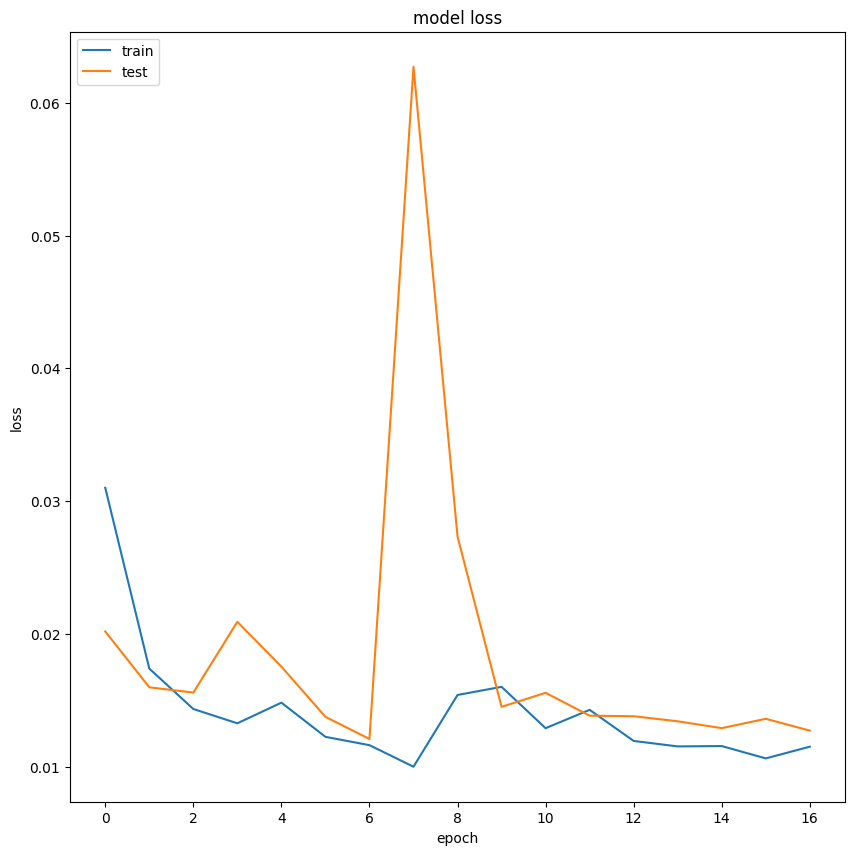

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0070 - mae: 0.0580 - r2_keras: 0.7623

MAE: 0.06742725521326065

R^2: 0.6699531674385071
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array_scaled, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

## Evaluate on Validation set

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


3/3 - 1s - 189ms/step - loss: 0.0050 - mean_absolute_error: 0.0506 - r2_keras: 0.7151

MAE: 0.05061139166355133

R^2: 0.715111255645752
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


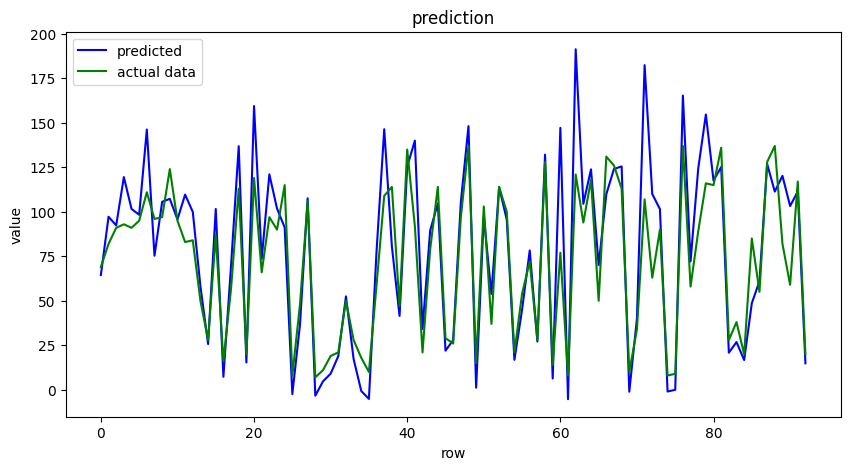

In [ ]:


y_pred_test_scaled = estimator.predict(seq_array_test_last)
y_pred_test = rul_scaler.inverse_transform(y_pred_test_scaled)

y_true_test = rul_scaler.inverse_transform(label_array_test_last)

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

label_array_test_last_scaled = rul_scaler.transform(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})


    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last_scaled, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test_scaled = estimator.predict(seq_array_test_last)

    y_pred_test = rul_scaler.inverse_transform(y_pred_test_scaled)
    y_true_test = rul_scaler.inverse_transform(label_array_test_last_scaled)

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_true_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2 = r2_score(y_true_test, y_pred_test)

print(f"\nReal-world MAE: {mae:.2f} cycles")
print(f"RMSE: {rmse:.2f} cycles")
print(f"R² Score (real): {r2:.4f}")


Real-world MAE: 15.74 cycles
RMSE: 22.02 cycles
R² Score (real): 0.7118
